In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Tuple
import pandas as pd

In [2]:
def intraday_parabolic_seasonality(n_steps: int, open_amplitude: float , close_amplitude: float ) -> np.ndarray:
    """
    n_steps is the number of time intervals 
    open_amplitude is the ratio between volatility at market open and day-low volatility
    close_amplitude is the ratio between volatility at market close and day-low volatility

    return a normalised parabolic intraday seasonal factor s_t such that mean(s_t^2) = 1
    """
    if open_amplitude < 1.0 or close_amplitude < 1.0:
        raise ValueError("open_amplitude and close_ampplitude must be greater than 1.0")
    s = np.linspace(0.0, 1.0, n_steps)
    o = open_amplitude
    p = close_amplitude


    # Solve parabola f(u) = a u^2 + b u + c such that:
    # f(0) = c = o
    # f(1) = a + b + c = p
    # min f(u*) = 1 for some u* in [0,1]  -> equivalent to b^2 = 4 a (c - 1)

    b = -2 * ((o - 1) + np.sqrt((o - 1) * (p - 1)))
    a = p - o - b
    c = o 
    s = a * s ** 2 + b * s + c # parabolic equation
    # normalise so E[s^2] = 1 (preserves overall variance scale)
    s = s / np.sqrt(np.mean(s ** 2))
    return s


def simulate_coarse_garch_with_seasonality(
    rng: np.random._generator.Generator, 
    daily_vol: float,           # expected daily volatility
    open_amplitude: float,      # ratio between volatility at market open and day-low volatility
    close_amplitude: float,     # ratio between volatility at market close and day-low volatility
    trading_seconds: float,     # number of trading seconds to simulate
    dt_coarse: float,           # duration of each time interval
    alpha_g: float,             # GARCH(1,1) parameter
    beta_g: float,              # GARCH(1,1) parameter
    mu: float = 0.0,            # expected log-return within one interval
    burnin: int = 500
) -> Dict[str, np.ndarray]:
    """
    Simulate coarse-grid returns (e.g. 1s) with multiplicative intraday seasonality.

    Returns a dict with:
      'coarse_returns' : array (length = n_steps)
      'coarse_sigma'   : array same length (std dev per step after seasonality)
      's'              : seasonal factor multiplied to volatility
    """

    if alpha_g + beta_g >= 1.0:
        raise ValueError("alpha_g + beta_g must be < 1 (stationarity).")

    # 1) deterministic seasonal factor
    n_steps = int(np.ceil(trading_seconds / dt_coarse))
    s = intraday_parabolic_seasonality(n_steps, open_amplitude, close_amplitude)  # mean(s^2)=1

    # 2) GARCH for log-return r_t with no seasonality: sigma_t^2 = omega + alpha*r_{t-1}^2 + beta*sigma_{t-1}^2
    # map daily volatility to per-step variance
    var_daily = daily_vol ** 2
    var_step = var_daily / n_steps
    omega = var_step * (1.0 - alpha_g - beta_g) # since var_step is approximately E[sigma^2]
    # initialise
    sigma2 = np.zeros(n_steps + burnin, dtype=float) # sigma^2
    sigma = np.zeros(n_steps + burnin, dtype=float)
    r = np.zeros(n_steps + burnin, dtype=float)
    z = rng.standard_normal(n_steps + burnin)

    sigma2[0] = var_step
    sigma[0] = np.sqrt(sigma2[0])
    # simulate GARCH(1,1) returns (log-returns on grid)
    for t in range(1, n_steps + burnin):
        r[t] = sigma[t-1] * z[t-1]
        sigma2[t] = omega + alpha_g * (r[t] ** 2) + beta_g * sigma2[t-1]
        sigma[t] = np.sqrt(sigma2[t])

    # remove burnin
    sigma2 = sigma2[burnin: ]
    z = z[burnin: ]

    # add seasonality
    sigma2_seasonal = sigma2 * (s ** 2)
    sigma_seasonal = np.sqrt(sigma2_seasonal)

    r_seasonal = mu + sigma_seasonal * z

    return {
        'coarse_returns': r_seasonal,
        'coarse_sigma': sigma_seasonal,
        's': s,
    }


def simulate_trades(
    price0: float = 100.0,          # initial price of the stock
    daily_vol: float = 0.02,        # target daily volatility (std), e.g. 2%
    dt: float = 1.0,                # seconds (grid for volatility/mid-price)
    trading_seconds: float = 6.5 * 3600,  # Time period to simulate (in seconds)
    open_amplitude: float = 3.0,    # Ratio between market open volatility and day-low volatility
    close_amplitude: float = 2.0,   # Ratio between market close volatility and day-low volatility
    alpha_g: float = 0.05,          # GARCH(1,1) parameter for simulating mid-price
    beta_g: float = 0.94,           # GARCH(1,1) parameter for simulating mid-price
    lambda0: float = 5.0,           # base trades per second
    k_intensity: float = 2.0,       # sensitivity of intensity to volatility
    v0: float = 100.0,              # base volume scale
    vol_gamma: float = 1.0,         # scaling exponent of volume ~ sigma^gamma
    volume_noise_sigma: float = 2.00,      # log-normal noise for volumes
    micro_sigma: float = 1e-4,      # microstructure noise on log-price
    tick_size: float = 0.01,
    impact_coeff: float = 0.0,      # for price impact (not included here)
    impact_exponent: float = 0.5,
    seed: int | None = 42,
):
    """
    Return dict with arrays: 
        'trade_times': seconds from start, length depends on the number of trades (random)
        'prices': trade prices, same length
        'volumes': trade volumes, same length
        'dollar': dollar exchanged per trade, same length
    """
    rng = np.random.default_rng(seed)

    # 1) grid and GARCH setup
    n_steps = int(np.ceil(trading_seconds / dt))
    times_grid = np.arange(n_steps + 1) * dt  # [0, dt, 2dt, ..., n * dt]

    garch_returns = simulate_coarse_garch_with_seasonality(rng, daily_vol, open_amplitude, close_amplitude, trading_seconds, dt, alpha_g, beta_g)
    r = garch_returns['coarse_returns']
    sigma = garch_returns['coarse_sigma']

    # 2) mid-price path: use cumulative log-returns 
    log_price = np.log(price0) + np.cumsum(r)  # r are log-returns
    midprice_grid = np.exp(log_price)
    midprice_grid = np.insert(midprice_grid, 0, price0)

    # 3) trade arrival: inhomogeneous Poisson on grid
    sigma_mean = sigma.mean()
    # intensity per second on grid (ensure positive)
    lambda_grid = lambda0 * (1.0 + k_intensity * (sigma / sigma_mean - 1.0))
    lambda_grid = np.maximum(lambda_grid, 1e-6)

    trade_times = []
    trade_prices = []
    trade_vols = []

    # iterate grid intervals and generate Poisson number of trades per interval
    for i in range(n_steps):
        lam = lambda_grid[i] * dt  # expected trades in the dt_grid interval
        # Poisson number of trades in the interval
        n_trades = rng.poisson(lam)

        if n_trades == 0: # no trades in the interval -> go to the next grid interval
            continue

        interval_start = times_grid[i]

        for j in range(n_trades):
            t_trade = interval_start + rng.uniform(0.0, dt) # uniformly distribute trades inside the interval
            # interpolate between grid points: find fractional position
            pos = (t_trade / dt)
            idx_low = int(np.floor(pos))
            idx_high = idx_low + 1
            w = pos - idx_low
            # interpolate log-price, consistent with multiplicative returns
            log_p_low = np.log(midprice_grid[idx_low])
            log_p_high = np.log(midprice_grid[idx_high])
            mp = np.exp((1 - w) * log_p_low + w * log_p_high)

            # sample volume: lognormal around v0 scaled by sigma
            # scale factor from sigma at idx_low
            sigma_local = sigma[idx_low]
            vol_scale = v0 * (sigma_local / sigma_mean) ** vol_gamma
            vol = vol_scale * rng.lognormal(mean=0.0, sigma = volume_noise_sigma)
            # optional impact: push price by signed impact, compute sign from price changes; 
            # For simplicity we skip impact here, instead we add simple microstructure noise to log price (multiplicative)
            noise = rng.normal(scale = micro_sigma)
            trade_price = mp * np.exp(noise)

            trade_times.append(t_trade)
            trade_prices.append(trade_price)
            trade_vols.append(vol)

    # convert to numpy arrays and sort by time
    trade_times = np.array(trade_times)
    sort_idx = np.argsort(trade_times)
    trade_times = trade_times[sort_idx]
    trade_prices = np.array(trade_prices)[sort_idx]
    trade_vols = np.array(trade_vols)[sort_idx]

    # find trade prices in ticks (discretise)
    trade_prices = np.round(trade_prices / tick_size) * tick_size

    return {
        'trade_times': trade_times, 
        'prices': trade_prices,
        'volumes': trade_vols,
        'grid_sigma': sigma,
        'times_grid': times_grid,
        'midprice_grid': midprice_grid
    }


In [3]:
sim = simulate_trades(dt = 1.0)

# convert to dataframe for easy storage
data = {
    'time' : sim['trade_times'],
    'price' : sim['prices'],
    'volume' : sim['volumes']}
df = pd.DataFrame(data)

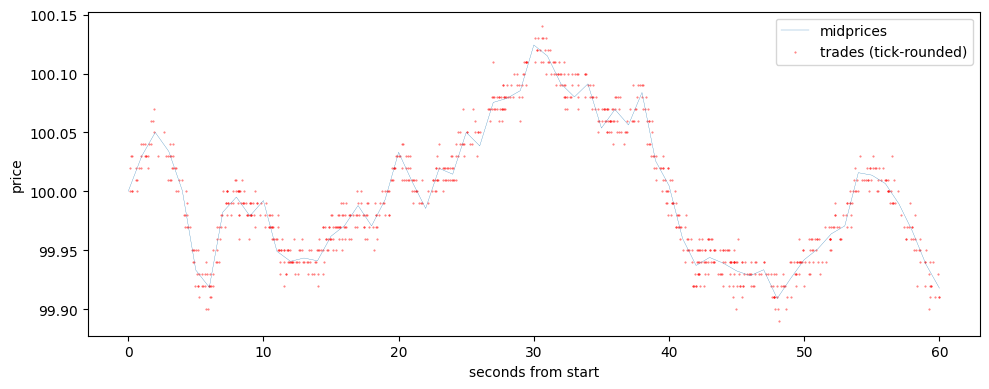

In [ ]:
# showcase 1, here we consider only the first 60 seconds after market open for clear demonstration
# The blue line is the midprice path generated by our GARCH model
# each red dot represent a simulated trade (with time and price), which as expected, follows the blue line closely with some noise.

trade_times = sim['trade_times']
times_grid = sim['times_grid']
midprices = sim['midprice_grid']
trade_prices = sim['prices']

trade_num = len(trade_times[trade_times < 60]) # number of trades within the first 60 seconds

plt.figure(figsize=(10,4))
plt.plot(times_grid[:61], midprices[:61], linewidth=0.2, label='midprices')
plt.scatter(trade_times[:trade_num], trade_prices[:trade_num], c = 'red', s=0.2, alpha=0.6, label='trades (tick-rounded)')
plt.xlabel('seconds from start')
plt.ylabel('price')
plt.legend()
plt.tight_layout()
plt.show()

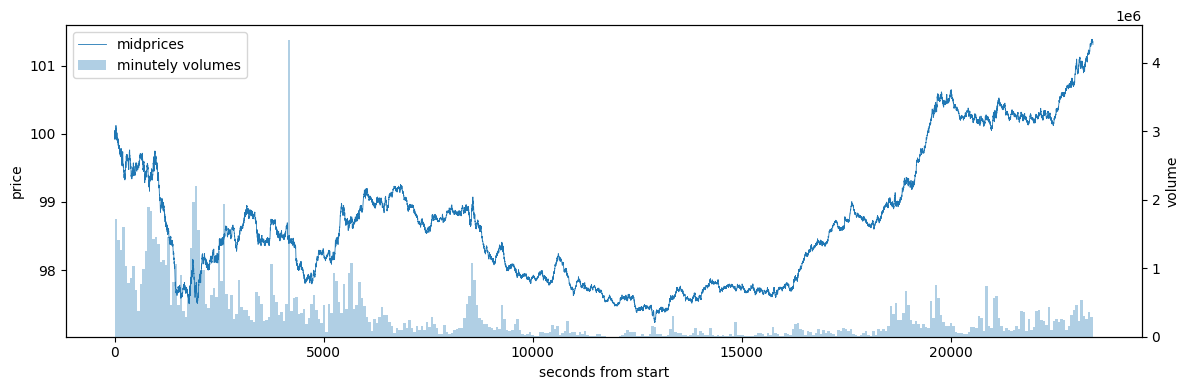

In [ ]:
# showcase 2
# the dark blue line is the whole-day midprice path (you can plot the trade prices instead, just looks a bit too wobble)
# the light blue bars are the minutely volumes

df['minute'] = (df['time'] // 60).astype(int) # find trade time in minutes

minute_vol = df.groupby('minute')['volume'].sum()  # sum all trade volumes in each minute (minutely volumes)             

fig, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(times_grid, midprices, linewidth = 0.6, label = 'midprices')
ax1.set_xlabel('seconds from start')
ax1.set_ylabel('price')

ax2 = ax1.twinx()
ax2.bar(np.arange(len(minute_vol)) * 60, minute_vol, width = 60.0, alpha=0.35,
        align = 'edge', label = 'minutely volumes')
ax2.set_ylabel('volume')

# combined legend from both axes
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper left')

plt.tight_layout()
plt.show()
